In [3]:
import argparse
import os
import datasets
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ddpm
import seaborn as sns

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset , Dataset

from tqdm.auto import tqdm

from positional_embeddings import PositionalEmbedding


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression , Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA

from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.formula.api import logit


In [4]:
class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.ff = nn.Linear(size, size)              # Couche linéaire
        self.act = nn.GELU()                         # Fonction d'activation GELU

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))              # Residual connection


class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_size: int = 128, hidden_layers: int = 3,
                 emb_size: int = 128, time_emb: str = "sinusoidal", input_emb: str = "sinusoidal"):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size, time_emb)                     # Embedding par rapport au temps
        self.input_mlps = nn.ModuleList([PositionalEmbedding(emb_size, input_emb, scale=25.0)
                                         for _ in range(input_dim)])                # Embedding pour chaque dimension de l'entrée

        concat_size = len(self.time_mlp.layer) + len(self.input_mlps) * emb_size
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]                  # Initialise la première couche
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))                                      # Crée les layers cachés
        layers.append(nn.Linear(hidden_size, input_dim))                           # Final layer de taille input_dim
        self.joint_mlp = nn.Sequential(*layers)                                    # Ajoute tous les layers

    def forward(self, x, t):
        x_embs = [self.input_mlps[i](x[:, i]) for i in range(x.size(1))]           # Embedding pour chaque dimension de x
        t_emb = self.time_mlp(t)
        x = torch.cat(x_embs + [t_emb], dim=-1)                                    # Concaténation des embeddings
        x = self.joint_mlp(x)                                                      # Application du réseau de neurones
        return x


# Données : Website historique

In [7]:
df = pd.read_csv("mon_dataset.csv")
df[["A"]+["B"]].describe()

,A,B
count,40000.000000,40000.000000
mean,0.047400,0.001150
std,0.212496,0.033893
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [3]:
df = pd.read_json('parcoursuserDatabaseFinalABTastyDataset1_2023.JSON')
df.head(5)

,fullVisitorId,transactions,size_time_serie,presence_time_serie,time_spend_time_serie,connexion_time_time_serie
0,13022610131436100,0,28,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[185848, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,13022614071765116,0,5,"[1, 0, 0, 0, 1]","[17562, 0, 0, 0, 2894880]","[18, 0, 0, 0, 14]"
2,13022620563064236,1,10,"[1, 0, 0, 0, 0, 0, 1, 1, 1, 1]","[19500172, 0, 0, 0, 0, 0, 96067, 253384, 74122...","[15, 0, 0, 0, 0, 0, 14, 8, 14, 7]"
3,13022712313065416,0,6,"[1, 0, 0, 1, 0, 1]","[1450416, 0, 0, 6707518, 0, 37761580]","[13, 0, 0, 18, 0, 13]"
4,13022713270294130,0,0,[1],[8201446],[11]


In [4]:
df.describe()

,fullVisitorId,transactions,size_time_serie
count,7.987100e+04,79871.000000,79871.000000
mean,1.799434e+16,0.032427,2.917191
std,3.892371e+14,0.177133,6.381899
min,1.302261e+16,0.000000,0.000000
25%,1.809252e+16,0.000000,0.000000
50%,1.810091e+16,0.000000,0.000000
75%,1.810242e+16,0.000000,1.000000
max,1.811122e+16,1.000000,33.000000


In [5]:
def get_list_types(lst):
    """
    Retourne un ensemble des types de données uniques dans la liste.
    """
    return set(type(item).__name__ for item in lst)

def analyze_column_types(df, column_name):
    """
    Analyse les types de données dans une colonne contenant des listes.
    
    :param df: DataFrame pandas
    :param column_name: Nom de la colonne à analyser
    :return: Un nouveau DataFrame avec les résultats de l'analyse
    """
    # Appliquer la fonction get_list_types à chaque liste dans la colonne
    types_series = df[column_name].apply(get_list_types)
    
    # Créer un DataFrame avec les résultats
    result_df = pd.DataFrame({
        'index': df.index,
        'types': types_series,
        'list_length': df[column_name].apply(len)
    })
    
    # Compter les occurrences de chaque combinaison de types
    type_counts = result_df['types'].value_counts()
    
    print("Analyse des types de données dans la colonne :", column_name)
    print("\nCombinations de types trouvées et leur fréquence :")
    print(type_counts)
    
   
    
    return result_df

# Utilisation de la fonction
result = analyze_column_types(df, "time_spend_time_serie")
result = analyze_column_types(df, "presence_time_serie")
result = analyze_column_types(df, "connexion_time_time_serie")

Analyse des types de données dans la colonne : time_spend_time_serie

Combinations de types trouvées et leur fréquence :
types
{int}         79857
{int, str}       12
{NoneType}        2
Name: count, dtype: int64
Analyse des types de données dans la colonne : presence_time_serie

Combinations de types trouvées et leur fréquence :
types
{int}    79871
Name: count, dtype: int64
Analyse des types de données dans la colonne : connexion_time_time_serie

Combinations de types trouvées et leur fréquence :
types
{int}    79871
Name: count, dtype: int64


In [6]:
def remove_non_int_rows(df, column_name):
    # Fonction pour vérifier si tous les éléments sont des entiers
    def all_ints(lst):
        return all(isinstance(item, int) for item in lst)
    
    # Compter le nombre de lignes avant la suppression
    initial_count = len(df)
    
    # Créer un masque pour les lignes à conserver
    mask = df[column_name].apply(all_ints)
    
    # Appliquer le masque pour ne garder que les lignes avec des entiers
    df_cleaned = df[mask].copy()
    
    # Compter le nombre de lignes supprimées
    removed_count = initial_count - len(df_cleaned)
    
    print(f"Nombre de lignes avant suppression : {initial_count}")
    print(f"Nombre de lignes après suppression : {len(df_cleaned)}")
    print(f"Nombre de lignes supprimées : {removed_count}")
    
    return df_cleaned



# Utilisation de la fonction
df = remove_non_int_rows(df, "time_spend_time_serie")


df.head()

def longest_streak(series):
    max_streak = 0
    current_streak = 0
    for num in series:
        if num == 1:
            current_streak += 1
            if current_streak > max_streak:
                max_streak = current_streak
        else:
            current_streak = 0
    return max_streak




Nombre de lignes avant suppression : 79871
Nombre de lignes après suppression : 79857
Nombre de lignes supprimées : 14


In [7]:
df["total_time_spent"]=df["time_spend_time_serie"].apply(sum)
df["Number_connexion_times"]=df["presence_time_serie"].apply(sum)
df['highest_connexion_streak'] = df['presence_time_serie'].apply(longest_streak)
df.drop('fullVisitorId', axis=1, inplace=True)
df.head(5)

,transactions,size_time_serie,presence_time_serie,time_spend_time_serie,connexion_time_time_serie,total_time_spent,Number_connexion_times,highest_connexion_streak
0,0,28,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[185848, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",89582735,4,2
1,0,5,"[1, 0, 0, 0, 1]","[17562, 0, 0, 0, 2894880]","[18, 0, 0, 0, 14]",2912442,2,1
2,1,10,"[1, 0, 0, 0, 0, 0, 1, 1, 1, 1]","[19500172, 0, 0, 0, 0, 0, 96067, 253384, 74122...","[15, 0, 0, 0, 0, 0, 14, 8, 14, 7]",22140033,5,4
3,0,6,"[1, 0, 0, 1, 0, 1]","[1450416, 0, 0, 6707518, 0, 37761580]","[13, 0, 0, 18, 0, 13]",45919514,3,1
4,0,0,[1],[8201446],[11],8201446,1,1


In [8]:
df.describe()

,transactions,size_time_serie,total_time_spent,Number_connexion_times,highest_connexion_streak
count,79857.000000,79857.000000,7.985700e+04,79857.000000,79857.000000
mean,0.032333,2.914698,1.630566e+07,1.776989,1.240079
std,0.176884,6.378226,9.930219e+07,2.191258,0.989623
min,0.000000,0.000000,0.000000e+00,1.000000,1.000000
25%,0.000000,0.000000,6.325500e+04,1.000000,1.000000
50%,0.000000,0.000000,2.928620e+05,1.000000,1.000000
75%,0.000000,1.000000,2.094492e+06,1.000000,1.000000
max,1.000000,33.000000,6.320772e+09,27.000000,25.000000


## Quelles corrélations à tester ?

Transactions f° size_time_serie
<br>
Transactions f° total_time_spent
<br>
Transactions f° Number_connexion_times
<br>
Transactions f° Highest_presence_time_streak
<br>
time_spend_time_serie f° connexion_time_time_serie
<br>
Mean_spent_time f° Number_connexion_times

Transactions f° size_time_serie

In [9]:


# Liste des colonnes spécifiques à analyser
columns_to_analyze = ['total_time_spent', 'Number_connexion_times',"size_time_serie","highest_connexion_streak"]

for column in columns_to_analyze:
    if column in df.columns and df[column].dtype != 'object':
        model = logit(f"transactions ~ {column}", data=df).fit()
        print(f"Logistic regression for transaction and {column}:")
        print(model.summary())
        print("\n" + "="*50 + "\n")  # Séparateur pour une meilleure lisibilité

Optimization terminated successfully.
         Current function value: 0.125108
         Iterations 8
Logistic regression for transaction and total_time_spent:
                           Logit Regression Results                           
Dep. Variable:           transactions   No. Observations:                79857
Model:                          Logit   Df Residuals:                    79855
Method:                           MLE   Df Model:                            1
Date:                Fri, 23 Aug 2024   Pseudo R-squ.:                  0.1237
Time:                        13:32:10   Log-Likelihood:                -9990.7
converged:                       True   LL-Null:                       -11400.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.6842      0.023

Dans toutes ces régressions logistiques, le R^2 est bas , donc le modèle n'explique qu'une faible partie de la variabilité des données.

In [10]:


# Liste des variables à analyser
variables_to_analyze = ['total_time_spent', 'Number_connexion_times', "size_time_serie","highest_connexion_streak"]

def discretize(series):
    """Fonction pour discrétiser une série en 4 catégories"""
    try:
        # Essayez d'abord avec qcut
        return pd.qcut(series, q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    except ValueError:
        # Si qcut échoue, utilisez cut avec des bins personnalisés
        min_val = series.min()
        max_val = series.max()
        bins = [min_val, min_val + (max_val - min_val)/4, min_val + 2*(max_val - min_val)/4, 
                min_val + 3*(max_val - min_val)/4, max_val]
        return pd.cut(series, bins=bins, labels=['Low', 'Medium-Low', 'Medium-High', 'High'], include_lowest=True)

for column in variables_to_analyze:
    if column in df.columns:
        # Discrétisation de la variable numérique
        df[f'{column}_cat'] = discretize(df[column])
        
        # Création de la table de contingence
        contingency_table = pd.crosstab(df['transactions'], df[f'{column}_cat'])
        
        # Test du chi-carré
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        print(f"Chi-square test for transaction and {column}:")
        print(f"chi2 = {chi2:.4f}")
        print(f"p-value = {p_value:.4f}")
        print(f"degrees of freedom = {dof}")
        print("\nContingency table:")
        print(contingency_table)
        print("\n" + "="*50 + "\n")


Chi-square test for transaction and total_time_spent:
chi2 = 7279.2224
p-value = 0.0000
degrees of freedom = 3

Contingency table:
total_time_spent_cat    Low  Medium-Low  Medium-High   High
transactions                                               
0                     19938       19950        19915  17472
1                        28          13           49   2492


Chi-square test for transaction and Number_connexion_times:
chi2 = 4938.7561
p-value = 0.0000
degrees of freedom = 3

Contingency table:
Number_connexion_times_cat    Low  Medium-Low  Medium-High  High
transactions                                                    
0                           75395        1580          248    52
1                            1892         512          143    35


Chi-square test for transaction and size_time_serie:
chi2 = 5123.3158
p-value = 0.0000
degrees of freedom = 3

Contingency table:
size_time_serie_cat    Low  Medium-Low  Medium-High  High
transactions                            

In [11]:
import statsmodels.api as sm

# Ajoutez une constante à vos variables indépendantes
X = sm.add_constant(df[['total_time_spent', 'Number_connexion_times', 'size_time_serie',"highest_connexion_streak"]])
y = df['transactions']

# Créez et ajustez le modèle
model = sm.Logit(y, X).fit()

# Affichez le résumé du modèle
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.112601
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           transactions   No. Observations:                79857
Model:                          Logit   Df Residuals:                    79852
Method:                           MLE   Df Model:                            4
Date:                Fri, 23 Aug 2024   Pseudo R-squ.:                  0.2113
Time:                        13:32:13   Log-Likelihood:                -8992.0
converged:                       True   LL-Null:                       -11400.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -4.3269      0.033   -130.271      0.000      -4.392

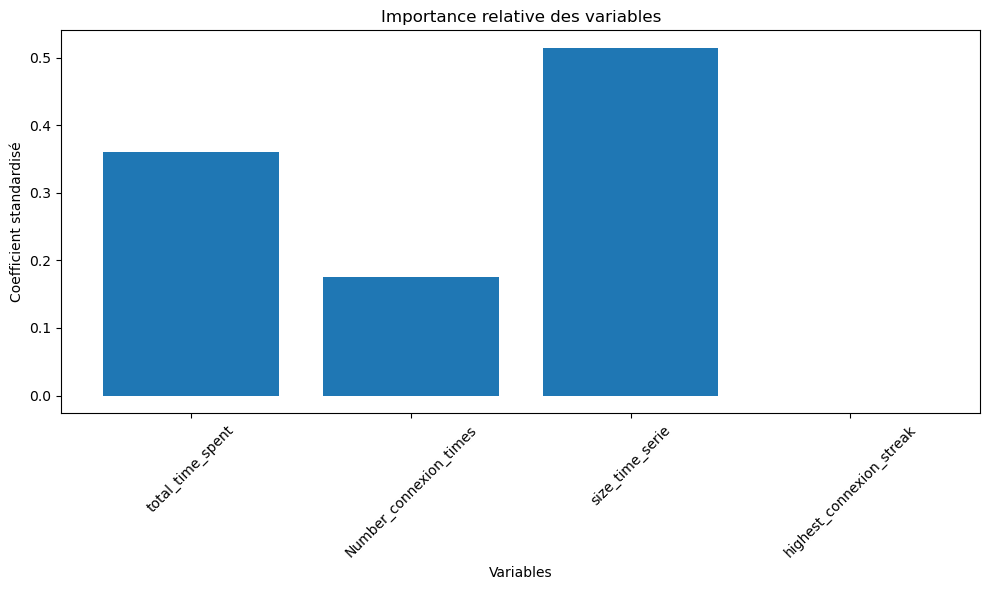

In [12]:
# Calculer les coefficients standardisés
std_X = X.std()
std_coef = model.params[1:] * std_X[1:]  # Exclure la constante

# Créer un graphique à barres des coefficients standardisés
plt.figure(figsize=(10, 6))
plt.bar(X.columns[1:], std_coef)
plt.title('Importance relative des variables')
plt.xlabel('Variables')
plt.ylabel('Coefficient standardisé')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Interprétation globale :
Le modèle suggère que toutes ces variables contribuent de manière significative et indépendante à la prédiction des transactions ; le temps passé en ligne , le nombre de connexions et le nombre total de jours entre la première connexion et la dernière influe sur la probabilité de transaction positivement ; augmenter ces variables augmentent la probabilité de transaction.


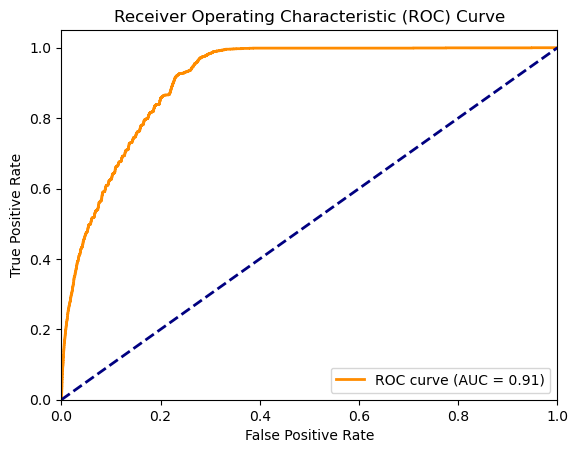

In [13]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculer les probabilités prédites
y_pred_proba = model.predict(X)

# Calculer la courbe ROC
fpr, tpr, _ = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


On voit tout d'abord que la courbe ROC s'élève rapidement vers le coin gauche , ce qui caractérise une bonne classification. Ensuite, l'AUC est de 0.91 ce qui est une excellente performance.

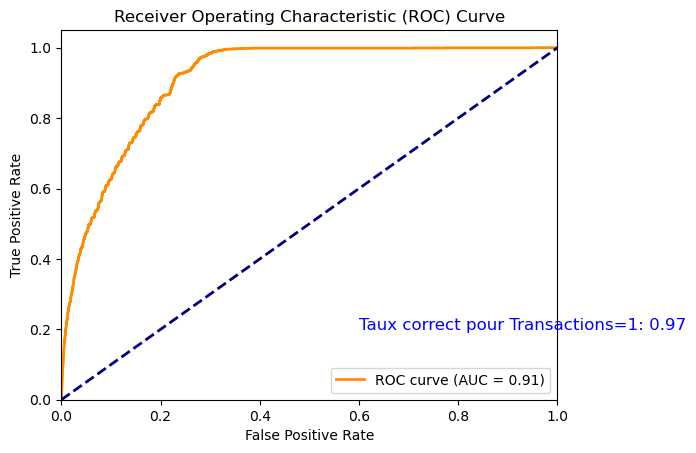

In [14]:
import numpy as np
from sklearn.metrics import roc_curve, auc, accuracy_score

# Calculer les probabilités prédites
y_pred_proba = model.predict(X)

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Calculer la sensibilité (taux de vrais positifs) au seuil optimal
optimal_idx = np.argmax(tpr - fpr)  # Index du seuil optimal basé sur la distance au point (0,1)
optimal_threshold = thresholds[optimal_idx]

# Prédictions binaires au seuil optimal
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Calculer la sensibilité (TPR) pour les cas où Transactions = 1
true_positives = np.sum((y == 1) & (y_pred_optimal == 1))
total_positives = np.sum(y == 1)
sensitivity = true_positives / total_positives

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Ajouter le taux de prédictions correctes pour Transactions=1
plt.text(0.6, 0.2, f'Taux correct pour Transactions=1: {sensitivity:.2f}', fontsize=12, color='blue')

plt.show()


Vérifier taux prédiction correctes pour transaction = 1
GAN time series
Etat de l'art génération time series

### Analyse A-B

In [14]:
df = pd.read_json('parcoursuserDatabaseFinalABTastyDataset1_2023.JSON')
dg = pd.read_json('parcours_reward_ABTastyDataset1_2023.JSON')

df_merged = pd.merge(dg, df, on='fullVisitorId', how='left')

df_merged = df_merged.drop(columns=['B'])

df_A = df_merged.dropna(subset=['A'])



df_merged.head(25)


,fullVisitorId,B,A,transactions,size_time_serie,presence_time_serie,time_spend_time_serie,connexion_time_time_serie
0,13022610131436100,0.0,NaN,0,28,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[185848, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,13022620563064236,NaN,1.0,1,10,"[1, 0, 0, 0, 0, 0, 1, 1, 1, 1]","[19500172, 0, 0, 0, 0, 0, 96067, 253384, 74122...","[15, 0, 0, 0, 0, 0, 14, 8, 14, 7]"
2,13022713270294130,NaN,0.0,0,0,[1],[8201446],[11]
3,13022721164897174,0.0,NaN,0,20,"[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[8197, 6255, 0, 17320, 4724, 0, 0, 0, 0, 0, 0,...","[5, 6, 0, 22, 12, 0, 0, 0, 0, 0, 0, 11, 0, 0, ..."
4,13030421473111988,NaN,0.0,0,12,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]","[67390, 0, 0, 0, 0, 0, 0, 0, 2329514, 0, 0, 79...","[21, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 15]"
5,13030715103604264,NaN,0.0,0,12,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]","[1310, 8003457, 0, 0, 0, 1218018, 0, 0, 0, 0, ...","[5, 18, 0, 0, 0, 20, 0, 0, 0, 0, 0, 11]"
6,13030813525084544,NaN,0.0,0,18,"[1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, ...","[483337, 12182987, 0, 0, 0, 0, 1292840, 758898...","[8, 11, 0, 0, 0, 0, 13, 9, 0, 13, 0, 0, 0, 0, ..."
7,13033122341720506,NaN,0.0,0,0,[1],[584483],[9]
8,13041708062955420,NaN,0.0,0,0,[1],[20623],[8]
9,13042223263884986,NaN,0.0,0,15,"[1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1]","[364990, 0, 0, 0, 0, 0, 1481278, 973528, 0, 26...","[19, 0, 0, 0, 0, 0, 20, 19, 0, 19, 19, 0, 8, 1..."


In [15]:
df= df_merged
df = remove_non_int_rows(df, "time_spend_time_serie")
df["total_time_spent"]=df["time_spend_time_serie"].apply(sum)
df["Number_connexion_times"]=df["presence_time_serie"].apply(sum)
df.drop('fullVisitorId', axis=1, inplace=True)
df.head(5)

Nombre de lignes avant suppression : 39372
Nombre de lignes après suppression : 39359
Nombre de lignes supprimées : 13


,B,A,transactions,size_time_serie,presence_time_serie,time_spend_time_serie,connexion_time_time_serie,total_time_spent,Number_connexion_times
0,0.0,NaN,0,28,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[185848, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",89582735,4
1,NaN,1.0,1,10,"[1, 0, 0, 0, 0, 0, 1, 1, 1, 1]","[19500172, 0, 0, 0, 0, 0, 96067, 253384, 74122...","[15, 0, 0, 0, 0, 0, 14, 8, 14, 7]",22140033,5
2,NaN,0.0,0,0,[1],[8201446],[11],8201446,1
3,0.0,NaN,0,20,"[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[8197, 6255, 0, 17320, 4724, 0, 0, 0, 0, 0, 0,...","[5, 6, 0, 22, 12, 0, 0, 0, 0, 0, 0, 11, 0, 0, ...",12988161,7
4,NaN,0.0,0,12,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]","[67390, 0, 0, 0, 0, 0, 0, 0, 2329514, 0, 0, 79...","[21, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 15]",10384434,3


In [16]:
# Créer le dataset avec les valeurs de A
df_A = df[df['A'].notna()].copy()

# Créer le dataset avec les valeurs de B
df_B = df[df['B'].notna()].copy()
df_A.describe()


,B,A,transactions,size_time_serie,total_time_spent,Number_connexion_times
count,0.0,22239.000000,22239.000000,22239.000000,2.223900e+04,22239.000000
mean,NaN,0.043392,0.043392,3.869104,2.336729e+07,2.112820
std,NaN,0.203743,0.203743,7.262231,1.181898e+08,2.666692
min,NaN,0.000000,0.000000,0.000000,0.000000e+00,1.000000
25%,NaN,0.000000,0.000000,0.000000,7.809950e+04,1.000000
50%,NaN,0.000000,0.000000,0.000000,4.779960e+05,1.000000
75%,NaN,0.000000,0.000000,3.000000,3.941746e+06,2.000000
max,NaN,1.000000,1.000000,33.000000,3.444280e+09,27.000000


In [17]:
df_B.describe()

,B,A,transactions,size_time_serie,total_time_spent,Number_connexion_times
count,17120.000000,0.0,17120.000000,17120.000000,1.712000e+04,17120.000000
mean,0.040129,NaN,0.040129,3.857301,2.429400e+07,2.148773
std,0.196266,NaN,0.196266,7.355455,1.250063e+08,2.814660
min,0.000000,NaN,0.000000,0.000000,0.000000e+00,1.000000
25%,0.000000,NaN,0.000000,0.000000,5.151875e+04,1.000000
50%,0.000000,NaN,0.000000,0.000000,3.911550e+05,1.000000
75%,0.000000,NaN,0.000000,3.000000,3.492845e+06,2.000000
max,1.000000,NaN,1.000000,33.000000,4.401504e+09,26.000000


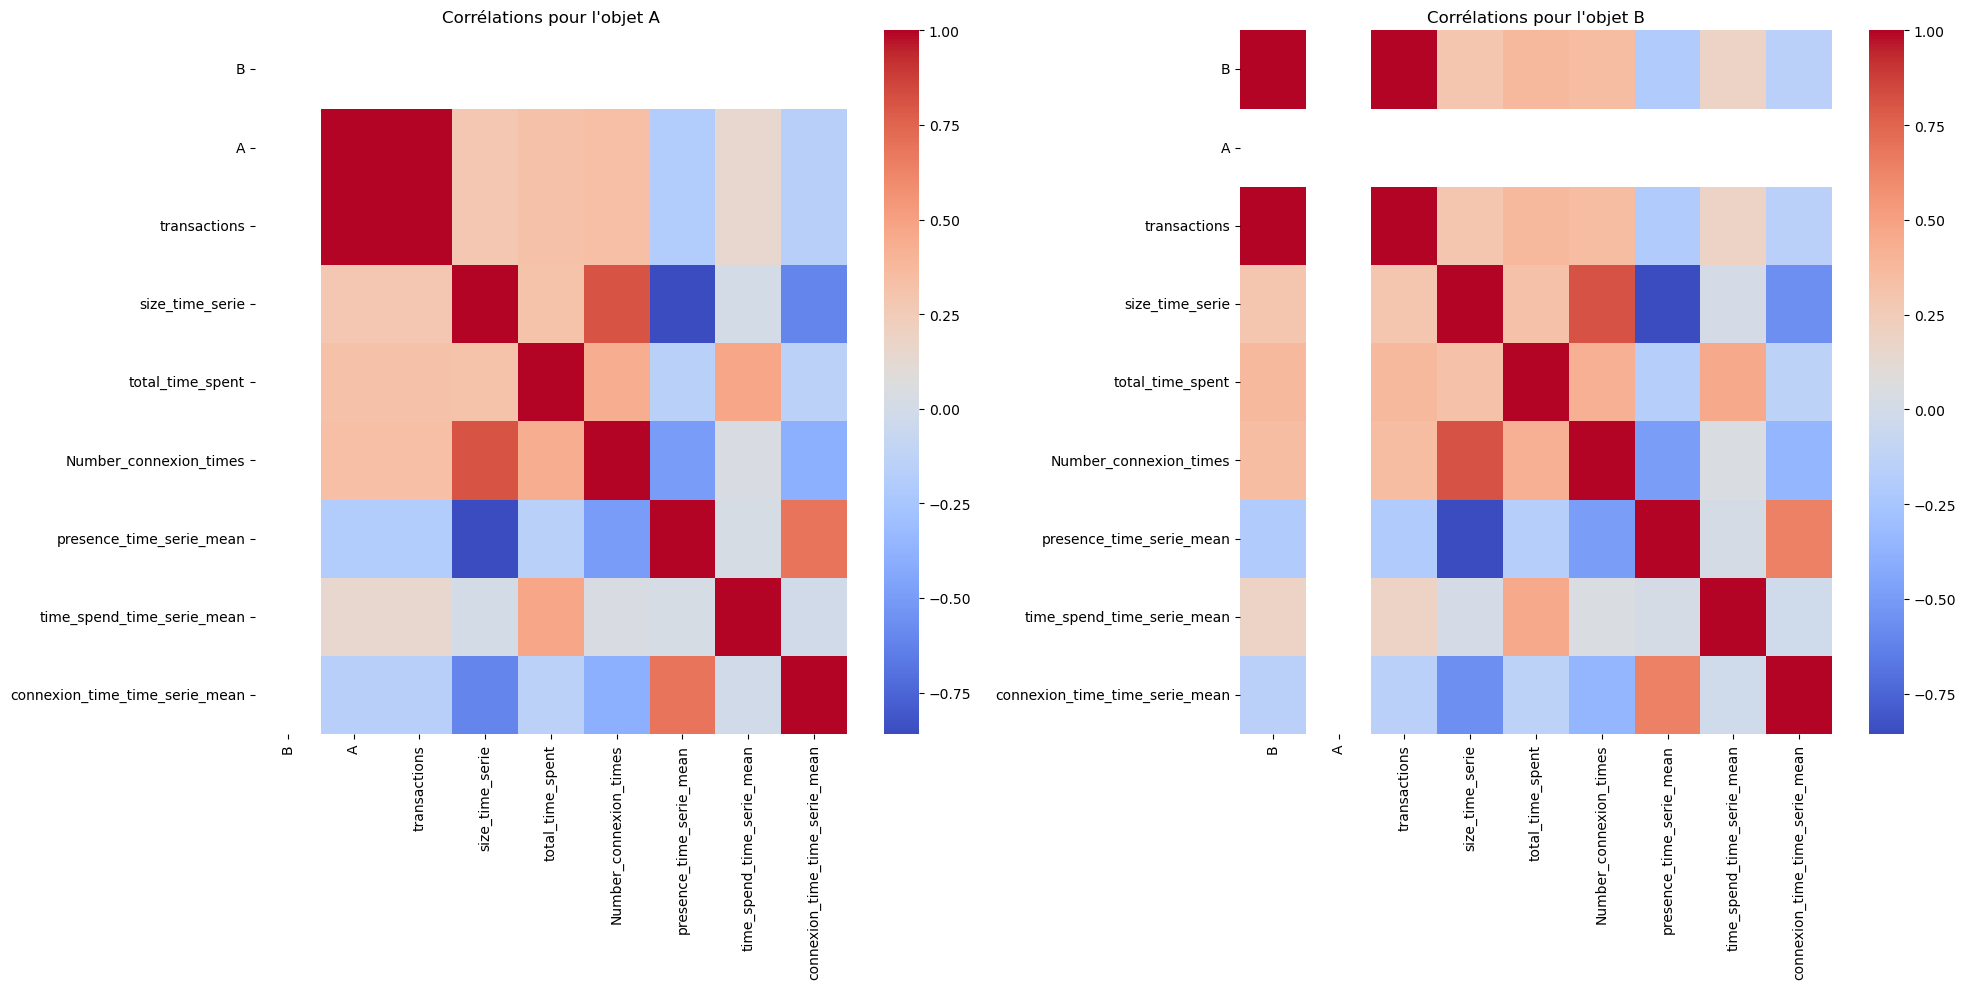

Colonnes traitées dans df_A: ['presence_time_serie', 'time_spend_time_serie', 'connexion_time_time_serie']
Colonnes traitées dans df_B: ['presence_time_serie', 'time_spend_time_serie', 'connexion_time_time_serie']


In [18]:
# Fonction pour vérifier si une colonne contient des listes
def contains_list(series):
    return series.apply(lambda x: isinstance(x, list)).any()

# Fonction pour extraire une caractéristique d'une liste (par exemple, la moyenne)
def extract_feature(x):
    if isinstance(x, list):
        return np.mean(x) if len(x) > 0 else np.nan
    return x

# Identifier les colonnes contenant des listes
list_columns_A = [col for col in df_A.columns if contains_list(df_A[col])]
list_columns_B = [col for col in df_B.columns if contains_list(df_B[col])]

# Traiter ces colonnes en extrayant une caractéristique
for col in list_columns_A:
    df_A[f'{col}_mean'] = df_A[col].apply(extract_feature)

for col in list_columns_B:
    df_B[f'{col}_mean'] = df_B[col].apply(extract_feature)

# Sélectionner uniquement les colonnes numériques pour la corrélation
numeric_columns_A = df_A.select_dtypes(include=[np.number]).columns
numeric_columns_B = df_B.select_dtypes(include=[np.number]).columns

# Calculer les corrélations
corr_A = df_A[numeric_columns_A].corr()
corr_B = df_B[numeric_columns_B].corr()

# Visualiser les matrices de corrélation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(corr_A, annot=False, cmap='coolwarm', ax=ax1)
ax1.set_title("Corrélations pour l'objet A")

sns.heatmap(corr_B, annot=False, cmap='coolwarm', ax=ax2)
ax2.set_title("Corrélations pour l'objet B")

plt.tight_layout()
plt.show()

# Afficher les colonnes traitées
print("Colonnes traitées dans df_A:", list_columns_A)
print("Colonnes traitées dans df_B:", list_columns_B)

De manière assez évidente , la colonne de transaction est corrélée à A et B , en effet , la colonne est égale au max entre A et B . De même , le nombre de connexions est corrélé à la période de connexion totale. Finalement, le temps total passé et le nombre de connexions semblent influencer légèrement la transaction.

# Générations de données

In [20]:
# 1. Compter combien de listes ont une taille supérieure à 20
count_over_20 = (df_merged['presence_time_serie'].apply(len) > 20).sum()
print(f"Nombre de listes avec une taille supérieure à 20 : {count_over_20}")

Nombre de listes avec une taille supérieure à 20 : 2061


In [21]:
def pad_list(lst, target_length=20, pad_value=0):
    return lst + [pad_value] * (target_length - len(lst))


def normalize_column(df, column_name):
    # Ignorer les NaN pour les calculs de min et max
    x_min = df[column_name].min()
    x_max = df[column_name].max()
    
    # Vérifier si toutes les valeurs non-NaN sont identiques
    if x_min == x_max:
        print(f"Attention : Toutes les valeurs non-NaN de {column_name} sont identiques. Normalisation ignorée.")
        return df
    
    a = 8 / (x_max - x_min)
    b = -a * (x_min + x_max) / 2
    
    
    # Appliquer la normalisation seulement aux valeurs non-NaN
    df[column_name] = df[column_name].apply(lambda x: x * a + b if not np.isnan(x) else x)
    
    return df


,fullVisitorId,B,A,transactions,size_time_serie,presence_time_serie,time_spend_time_serie,connexion_time_time_serie,presence_1,time_spend_1,...,presence_16,time_spend_16,presence_17,time_spend_17,presence_18,time_spend_18,presence_19,time_spend_19,presence_20,time_spend_20
0,13022610131436100,0.0,0.0,0,28,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[185848, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.0,0.185848,...,0.0,0.000000,0.0,0.0,1.0,0.515901,0.0,0.0,0.0,0.000000
1,13022620563064236,0.0,1.0,1,10,"[1, 0, 0, 0, 0, 0, 1, 1, 1, 1]","[19500172, 0, 0, 0, 0, 0, 96067, 253384, 74122...","[15, 0, 0, 0, 0, 0, 14, 8, 14, 7]",1.0,19.500172,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,13022713270294130,0.0,0.0,0,0,[1],[8201446],[11],1.0,8.201446,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,13022721164897174,0.0,0.0,0,20,"[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[8197, 6255, 0, 17320, 4724, 0, 0, 0, 0, 0, 0,...","[5, 6, 0, 22, 12, 0, 0, 0, 0, 0, 0, 11, 0, 0, ...",1.0,0.008197,...,1.0,12.936865,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.008881
4,13030421473111988,0.0,0.0,0,12,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]","[67390, 0, 0, 0, 0, 0, 0, 0, 2329514, 0, 0, 79...","[21, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 15]",1.0,0.067390,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [24]:
df = pd.read_json('parcoursuserDatabaseFinalABTastyDataset1_2023.JSON')
dg = pd.read_json('parcours_reward_ABTastyDataset1_2023.JSON')

df_merged = pd.merge(dg, df, on='fullVisitorId', how='left')

df_merged = remove_non_int_rows(df_merged, "time_spend_time_serie")


padded_series = df_merged['presence_time_serie'].apply(pad_list)
padded_series2= df_merged['time_spend_time_serie'].apply(pad_list)


for i in range(20):
    df_merged[f'presence_{i+1}'] = padded_series.apply(lambda x: x[i])
    df_merged[f'time_spend_{i+1}'] = padded_series2.apply(lambda x: x[i])
    
    
    
column_names = [f'presence_{i}' for i in range(1, 21)]
column_names2 = [f'time_spend_{i}' for i in range(1, 21)]


all_columns =  ["A", "B"] + column_names + column_names2

df_merged = df_merged.replace('NA', np.nan)
df_merged[all_columns] = df_merged[all_columns].astype(float).fillna(0)


df_merged[column_names2]=df_merged[column_names2]/(10**6)
df_merged['check A'] = np.where(df_merged['A'].isna(), -4, 4)
df_merged['check B'] = np.where(df_merged['B'].isna(), -4, 4)    
    

for i in range(1, 21):
    column_name = f'time_spend_{i}'
    if column_name in df_merged.columns:
        df_merged = normalize_column(df_merged, column_name)

        
df_merged['A'] = df_merged['A'].fillna(0)
df_merged['B'] = df_merged['B'].fillna(0)
df_merged.head()

Nombre de lignes avant suppression : 39372
Nombre de lignes après suppression : 39359
Nombre de lignes supprimées : 13


,fullVisitorId,B,A,transactions,size_time_serie,presence_time_serie,time_spend_time_serie,connexion_time_time_serie,presence_1,time_spend_1,...,presence_17,time_spend_17,presence_18,time_spend_18,presence_19,time_spend_19,presence_20,time_spend_20,check A,check B
0,13022610131436100,0.0,0.0,0,28,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[185848, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,-3.999188,...,0,-4.0,1,-3.996709,0,-4.0,0,-4.000000,-4,4
1,13022620563064236,0.0,1.0,1,10,"[1, 0, 0, 0, 0, 0, 1, 1, 1, 1]","[19500172, 0, 0, 0, 0, 0, 96067, 253384, 74122...","[15, 0, 0, 0, 0, 0, 14, 8, 14, 7]",1,-3.914806,...,0,-4.0,0,-4.000000,0,-4.0,0,-4.000000,4,-4
2,13022713270294130,0.0,0.0,0,0,[1],[8201446],[11],1,-3.964169,...,0,-4.0,0,-4.000000,0,-4.0,0,-4.000000,4,-4
3,13022721164897174,0.0,0.0,0,20,"[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[8197, 6255, 0, 17320, 4724, 0, 0, 0, 0, 0, 0,...","[5, 6, 0, 22, 12, 0, 0, 0, 0, 0, 0, 11, 0, 0, ...",1,-3.999964,...,0,-4.0,0,-4.000000,0,-4.0,1,-3.999947,-4,4
4,13030421473111988,0.0,0.0,0,12,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]","[67390, 0, 0, 0, 0, 0, 0, 0, 2329514, 0, 0, 79...","[21, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 15]",1,-3.999706,...,0,-4.0,0,-4.000000,0,-4.0,0,-4.000000,4,-4


In [25]:
all_columns =  ["A", "B"] + column_names + column_names2 +['check A','check B']
dataset = df_merged[all_columns].values

# Convertir en tensor PyTorch
tensor = torch.from_numpy(dataset).float()

# Créer le TensorDataset
dataset = TensorDataset(tensor)
data_tensor = dataset.tensors[0]

print(data_tensor.shape)
print(data_tensor)
print(len(all_columns))

torch.Size([39359, 44])
tensor([[ 0.,  0.,  1.,  ..., -4., -4.,  4.],
        [ 1.,  0.,  1.,  ..., -4.,  4., -4.],
        [ 0.,  0.,  1.,  ..., -4.,  4., -4.],
        ...,
        [ 0.,  0.,  1.,  ..., -4., -4.,  4.],
        [ 0.,  0.,  1.,  ..., -4., -4.,  4.],
        [ 0.,  0.,  1.,  ..., -4., -4.,  4.]])
44


In [34]:
num_epochs = 400
lr = 1e-4
num_timesteps = 100
hidden_size = 256
hidden_layers = 3
time_emb = "sinusoidal"
input_emb = "sinusoidal"
batch_size = 100
emb_size = 128
input_dim = len(all_columns)


dataloader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
model = MLP(input_dim, hidden_size, hidden_layers, emb_size, time_emb, input_emb)
noise_scheduler = ddpm.NoiseScheduler(num_timesteps, beta_end=0.02, beta_schedule="linear")

optimizer = torch.optim.AdamW(model.parameters(), lr)
global_step = 0
frames = []
losses = []


print("Training model")
for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, batch in enumerate(dataloader):
        batch = batch[0]
        noise = torch.randn(batch.shape).float()  # Assurez-vous que le bruit est de type float
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (batch.shape[0],)).long()

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noisy = noisy.float()  # Assurez-vous que le tenseur noisy est de type float
        noise_pred = model(noisy, timesteps)
        
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
    progress_bar.close()



Training model


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

In [35]:
print("Saving model...")
outdir = "exps/base"
os.makedirs(outdir, exist_ok=True)
torch.save(model.state_dict(), f"{outdir}/modelWEBFINALlr10-4.pth")

Saving model...


In [37]:
# Initialisation des listes pour stocker les moyennes, écarts-types et médianes
L_mean = []
L_std = []
L_median = []

for j in range(10):
    eval_batch_size = 39372
    num_timesteps = 100
    plot_step=10
    sample = torch.randn(eval_batch_size, input_dim)
    timesteps = list(range(num_timesteps))[::-1]
    samples = []

    for i, t in enumerate(tqdm(timesteps)):
        t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
        with torch.no_grad():
            residual = model(sample, t)
        sample = noise_scheduler.step(residual, t[0], sample)
        if (i + 1) % plot_step == 0:
            samples.append(sample.numpy())

    generated_data = samples[-1]
    df = pd.DataFrame(generated_data, columns=all_columns)

    for i in range(len(all_columns)-2):
        x_min, x_max = df[all_columns[i]].min(), df[all_columns[i]].max()
        y_min, y_max = df_merged[all_columns[i]].min(), df_merged[all_columns[i]].max()

        if y_max != y_min:
            a = (y_max - y_min) / (x_max - x_min)
            b = y_max - a * x_max
            df[all_columns[i]] = a * df[all_columns[i]] + b

    for column in ["A", "B"]:
        df[column] = (df[column] >= 0.5).astype(int)
    
    df.loc[df['check A'] < 0, 'A'] = np.nan
    df.loc[df['check B'] < 0, 'B'] = np.nan

    mean_A, mean_B = df['A'].mean(), df['B'].mean()
    std_A, std_B = df['A'].std(), df['B'].std()
    median_A, median_B = df['A'].median(), df['B'].median()
    
    L_mean.append([mean_A, mean_B])
    L_std.append([std_A, std_B])
    L_median.append([median_A, median_B])
    
    print(f"Jeu de données {j+1}:")
    print(f"  Moyenne - A: {mean_A}, B: {mean_B}")
    print(f"  Écart-type - A: {std_A}, B: {std_B}")
    print(f"  Médiane - A: {median_A}, B: {median_B}")

# Conversion des listes en arrays numpy
L_mean = np.array(L_mean)
L_std = np.array(L_std)
L_median = np.array(L_median)

# Calcul des moyennes finales pour chaque métrique
moyennes_finales = np.mean(L_mean, axis=0)
std_finales = np.mean(L_std, axis=0)
medianes_finales = np.mean(L_median, axis=0)

print("\nRésultats finaux:")
print("Moyennes des moyennes:")
print("  A:", moyennes_finales[0])
print("  B:", moyennes_finales[1])
print("Moyennes des écarts-types:")
print("  A:", std_finales[0])
print("  B:", std_finales[1])
print("Moyennes des médianes:")
print("  A:", medianes_finales[0])
print("  B:", medianes_finales[1])

  0%|          | 0/100 [00:00<?, ?it/s]

Jeu de données 1:
  Moyenne - A: 0.01523986217863769, B: 0.005831612197788847
  Écart-type - A: 0.12250825175274399, B: 0.07614431495134613
  Médiane - A: 0.0, B: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jeu de données 2:
  Moyenne - A: 0.0008499597387492171, B: 0.0012525348920434211
  Écart-type - A: 0.029142328309306208, B: 0.03537005323865841
  Médiane - A: 0.0, B: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jeu de données 3:
  Moyenne - A: 0.2674020370946938, B: 0.13585111542192047
  Écart-type - A: 0.44261371556838197, B: 0.3426407840603359
  Médiane - A: 0.0, B: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jeu de données 4:
  Moyenne - A: 0.0010280708027892009, B: 0.0005961251862891207
  Écart-type - A: 0.03204777342472346, B: 0.024409124083182233
  Médiane - A: 0.0, B: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jeu de données 5:
  Moyenne - A: 0.0007556227220197351, B: 0.0019271303824149352
  Écart-type - A: 0.027478815816053142, B: 0.043858093796442954
  Médiane - A: 0.0, B: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jeu de données 6:
  Moyenne - A: 0.0012522361359570662, B: 0.004581349086744228
  Écart-type - A: 0.03536557614961011, B: 0.06753247549533473
  Médiane - A: 0.0, B: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jeu de données 7:
  Moyenne - A: 0.016826277633580956, B: 0.0033456804875134426
  Écart-type - A: 0.128623070893461, B: 0.057746741363129704
  Médiane - A: 0.0, B: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jeu de données 8:
  Moyenne - A: 0.2845601436265709, B: 0.013842281879194632
  Écart-type - A: 0.4512148116952188, B: 0.11683959583100534
  Médiane - A: 0.0, B: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jeu de données 9:
  Moyenne - A: 0.016027936962750716, B: 0.38058887677208286
  Écart-type - A: 0.12558562144145016, B: 0.48554635891290104
  Médiane - A: 0.0, B: 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jeu de données 10:
  Moyenne - A: 0.0004444641984088182, B: 0.00619797046849365
  Écart-type - A: 0.021078102308437704, B: 0.078485221125472
  Médiane - A: 0.0, B: 0.0

Résultats finaux:
Moyennes des moyennes:
  A: 0.060438661109415814
  B: 0.055401467677448565
Moyennes des écarts-types:
  A: 0.14156580673593866
  B: 0.13285727628578087
Moyennes des médianes:
  A: 0.0
  B: 0.0


In [78]:
generated_data = samples[-1]
df = pd.DataFrame(generated_data, columns=all_columns)
    
for i in range(len(all_columns)-2):
    x_min ,x_max =df[all_columns[i]].min() , df[all_columns[i]].max()
    y_min , y_max = df_merged[all_columns[i]].min() , df_merged[all_columns[i]].max()
    
    if y_max != y_min :
        a=(y_max-y_min)/(x_max-x_min)
        b=y_max-a*x_max
        df[all_columns[i]]=a*df[all_columns[i]]+b
df['presence_1'] = df['presence_1'].apply(lambda x: 0 if x < 0.5 else 1)
#renormalisation

Col=["A","B"] +column_names
for column in Col:
    df[column] = (df[column] >= 0.5).astype(int)
#Presence et transaction 0 ou 1

df.loc[df['check A'] < 0, 'A'] = np.nan
df.loc[df['check B'] < 0, 'B'] = np.nan
#Simuler les NaN

df['transaction'] = df[['A', 'B']].max(axis=1).fillna(0)

for i in range(1, 21):
    column_name = f'time_spend_{i}'
    if column_name in df.columns:
        df[column_name] = np.round(df[column_name]).astype(int)
#arrondir à l'entier par soucis de lisibilité

cols = df.columns.tolist()
cols.remove('transaction')
cols.insert(2, 'transaction')
df = df[cols]


df.head(10)

,A,B,transaction,presence_1,presence_2,presence_3,presence_4,presence_5,presence_6,presence_7,...,time_spend_13,time_spend_14,time_spend_15,time_spend_16,time_spend_17,time_spend_18,time_spend_19,time_spend_20,check A,check B
0,0.0,NaN,0.0,1,0,0,1,0,0,1,...,558,387,493,347,133,443,809,327,3.910782,-3.795597
1,NaN,0.0,0.0,1,0,0,0,0,0,1,...,913,268,402,31,26,14,108,181,-4.045590,4.021294
2,0.0,NaN,0.0,1,0,0,0,0,1,0,...,95,59,282,183,63,99,822,71,3.716434,-3.908454
3,0.0,NaN,0.0,1,0,0,0,0,0,0,...,989,155,148,139,34,16,132,88,2.757301,-3.791925
4,NaN,0.0,0.0,1,0,0,1,0,0,0,...,263,261,244,560,237,295,293,371,-4.030721,4.105596
5,NaN,0.0,0.0,1,0,0,0,0,1,1,...,764,275,193,280,406,133,474,288,-4.028588,4.017562
6,0.0,NaN,0.0,1,0,0,0,0,0,0,...,689,245,316,102,371,269,463,265,3.949123,-3.933426
7,0.0,NaN,0.0,1,0,0,1,0,0,1,...,81,140,391,453,101,112,782,603,3.070143,-3.604497
8,0.0,0.0,0.0,1,0,1,0,0,0,0,...,717,113,242,209,185,365,189,279,2.794520,0.722861
9,0.0,NaN,0.0,1,0,0,0,0,0,0,...,750,673,335,206,238,799,526,321,3.964870,-3.984332


In [1]:
df[["A","B"]].describe()

NameError: name 'df' is not defined

In [80]:
dt = pd.read_json('parcoursuserDatabaseFinalABTastyDataset1_2023.JSON')
dg = pd.read_json('parcours_reward_ABTastyDataset1_2023.JSON')
df_merged = pd.merge(dg, dt, on='fullVisitorId', how='left')
df_merged = remove_non_int_rows(df_merged, "time_spend_time_serie")

padded_series = df_merged['presence_time_serie'].apply(pad_list)
padded_series2= df_merged['time_spend_time_serie'].apply(pad_list)

for i in range(20):
    df_merged[f'presence_{i+1}'] = padded_series.apply(lambda x: x[i])
for i in range(20):
    df_merged[f'time_spend_{i+1}'] = padded_series2.apply(lambda x: x[i])/(10**6)

df_merged.drop('fullVisitorId', axis=1, inplace=True)
df_merged.drop('presence_time_serie' , axis=1 , inplace=True)
df_merged.drop('time_spend_time_serie' , axis=1 , inplace=True)
df_merged.drop('connexion_time_time_serie' , axis=1 , inplace=True)
df_merged[["A" , "B"]].describe()
#df_merged.head()

Nombre de lignes avant suppression : 39372
Nombre de lignes après suppression : 39359
Nombre de lignes supprimées : 13


,A,B
count,22239.000000,17120.000000
mean,0.043392,0.040129
std,0.203743,0.196266
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


Tout d'abord, sur 10 générations la moyenne des moyennes pour A est à peu près la même que la moyenne du dataset de base . Quand à la moyenne des moyennes de B , elle est 1.5 fois trop petite. Si on s'intéresse désormais à la médiane , les deux correspondent à ce qu'on s'attendait. Finalement, l'écart type est 10 fois plus petit pour les valeurs de A , et du bon ordre de grandeur pour B. La génération de données sur ces colonnes est donc décente. 

Intéressons nous alors aux colonnes de présence

In [81]:
df[column_names].describe()

,presence_1,presence_2,presence_3,presence_4,presence_5,presence_6,presence_7,presence_8,presence_9,presence_10,presence_11,presence_12,presence_13,presence_14,presence_15,presence_16,presence_17,presence_18,presence_19,presence_20
count,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000
mean,0.999975,0.001245,0.319745,0.015315,0.001143,0.185411,0.339378,0.078558,0.022097,0.371635,0.271640,0.210607,0.006172,0.000076,0.319059,0.201742,0.452098,0.120492,0.385731,0.288479
std,0.005040,0.035257,0.466384,0.122806,0.033789,0.388636,0.473504,0.269052,0.147001,0.483248,0.444811,0.407745,0.078320,0.008729,0.466118,0.401306,0.497706,0.325540,0.486774,0.453061
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [82]:
df_merged[column_names].describe()

,presence_1,presence_2,presence_3,presence_4,presence_5,presence_6,presence_7,presence_8,presence_9,presence_10,presence_11,presence_12,presence_13,presence_14,presence_15,presence_16,presence_17,presence_18,presence_19,presence_20
count,39359.0,39359.000000,39359.00000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.00000,39359.000000
mean,1.0,0.080388,0.06461,0.059478,0.047206,0.040499,0.058741,0.053228,0.057166,0.053914,0.055337,0.048045,0.042862,0.055616,0.045225,0.048375,0.048528,0.056658,0.04370,0.038212
std,0.0,0.271897,0.24584,0.236520,0.212083,0.197129,0.235143,0.224491,0.232163,0.225851,0.228639,0.213864,0.202548,0.229182,0.207799,0.214561,0.214881,0.231191,0.20443,0.191711
min,1.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,1.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,1.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,1.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,1.0,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


On observe que tous les quartiles ont été bien représentés pour les jours de présence. Quand aux moyennes, elles sont toutes du même ordre de grandeur , mais moins précises pour les premiers jours. De même pour les écarts type. 

Analysons les temps passés par séries , puis on essayera de voir si lorsque presence_i =0 , time_spend_i =0 également.

In [83]:
df[column_names2].describe()

,time_spend_1,time_spend_2,time_spend_3,time_spend_4,time_spend_5,time_spend_6,time_spend_7,time_spend_8,time_spend_9,time_spend_10,time_spend_11,time_spend_12,time_spend_13,time_spend_14,time_spend_15,time_spend_16,time_spend_17,time_spend_18,time_spend_19,time_spend_20
count,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000
mean,564.003861,469.246749,275.629940,279.712638,245.147846,205.519227,207.575358,329.484456,296.843467,292.164076,265.796962,213.772503,426.693081,387.431550,256.506400,273.786574,191.164076,326.190161,592.881642,306.021157
std,326.945837,298.015601,202.616049,269.487777,163.027600,132.110892,214.430492,250.469918,242.240010,260.312699,195.537830,196.776522,264.490065,267.943735,125.165173,245.319844,140.649355,227.895132,320.776898,222.101433
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,292.000000,243.000000,141.000000,103.000000,113.000000,91.000000,85.000000,152.000000,109.000000,108.000000,119.000000,81.000000,212.000000,184.000000,177.000000,112.000000,63.000000,141.000000,329.000000,138.000000
50%,506.000000,413.000000,225.000000,198.000000,224.000000,210.000000,126.000000,248.000000,227.000000,211.000000,190.000000,140.000000,406.000000,296.000000,264.000000,192.000000,165.000000,271.000000,564.000000,245.000000
75%,820.000000,672.000000,355.000000,307.000000,358.000000,297.000000,203.000000,506.000000,442.000000,334.000000,333.000000,231.000000,622.000000,582.000000,339.000000,320.000000,306.000000,500.000000,836.000000,446.000000
max,1831.000000,1765.000000,1301.000000,1747.000000,943.000000,759.000000,1507.000000,1411.000000,1392.000000,1534.000000,1301.000000,1275.000000,1491.000000,1575.000000,789.000000,1498.000000,724.000000,1254.000000,1634.000000,1339.000000


In [84]:
df_merged[column_names2].describe()

,time_spend_1,time_spend_2,time_spend_3,time_spend_4,time_spend_5,time_spend_6,time_spend_7,time_spend_8,time_spend_9,time_spend_10,time_spend_11,time_spend_12,time_spend_13,time_spend_14,time_spend_15,time_spend_16,time_spend_17,time_spend_18,time_spend_19,time_spend_20
count,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000
mean,6.814374,1.115583,0.822607,0.768700,0.645295,0.578930,0.684937,0.797196,0.744486,0.783105,0.734430,0.541158,0.720798,0.835030,0.586891,0.755884,0.771310,1.049381,0.969865,0.614472
std,44.042546,20.315003,14.260112,16.517861,12.336024,10.767106,14.354503,15.421609,13.633480,14.908634,13.296938,11.654966,16.890564,15.129999,9.955369,14.199671,12.544715,18.237266,18.297534,12.801165
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.030543,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.238631,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.422668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1831.122712,1765.269726,1301.029843,1746.870532,943.308616,759.313209,1506.955224,1410.692171,1391.601146,1533.652409,1301.030383,1274.724828,1490.646635,1574.801676,788.794520,1497.551888,723.989529,1253.961298,1633.965828,1339.384179


Cette fois ci , que ce soient la moyenne , l'écart type ou les quartiles, tout est très mal prédits . Essayons de voir si en synchronisant les 0 de la catégorie presence_i et de la catégorie time_spend_i, les time_spend sont mieux prédits.

In [85]:
for i in range(1, 21):  # Pour les colonnes de 1 à 20
    presence_col = f'presence_{i}'
    time_spend_col = f'time_spend_{i}'
    
    df.loc[df[presence_col] == 0, time_spend_col] = 0

df[column_names2].describe()

,time_spend_1,time_spend_2,time_spend_3,time_spend_4,time_spend_5,time_spend_6,time_spend_7,time_spend_8,time_spend_9,time_spend_10,time_spend_11,time_spend_12,time_spend_13,time_spend_14,time_spend_15,time_spend_16,time_spend_17,time_spend_18,time_spend_19,time_spend_20
count,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000
mean,563.978132,0.837042,102.303998,5.152977,0.377934,52.285101,82.497257,32.180001,9.582368,124.796404,83.105024,52.032434,3.440973,0.025983,98.916768,61.526516,106.898456,51.576145,260.990679,104.898024
std,326.950362,25.730492,188.811699,52.268158,11.899143,120.067363,178.367160,128.892766,72.502175,227.914717,171.997541,137.189522,46.329978,3.209864,156.547534,166.287119,149.234195,158.984284,381.573310,204.984179
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,506.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,820.000000,0.000000,169.000000,0.000000,0.000000,0.000000,105.000000,0.000000,0.000000,189.000000,107.000000,0.000000,0.000000,0.000000,232.000000,0.000000,195.000000,0.000000,517.000000,137.000000
max,1831.000000,1264.000000,1301.000000,1418.000000,664.000000,664.000000,1507.000000,1240.000000,1145.000000,1534.000000,1301.000000,1167.000000,1163.000000,501.000000,720.000000,1446.000000,722.000000,1164.000000,1634.000000,1339.000000


Même en synchronisant les presence aux time spend , les moyennes sont toujours très mauvaises.

On finira par analyser les tailles des listes générées.

In [86]:
def synchronize_lists(row):
    presence_list = row['presence_list']
    time_spend_list = row['time_spend_list']
    
    assert len(presence_list) == len(time_spend_list), "Les listes doivent avoir la même longueur"
    
    synchronized_time_spend = [
        0 if presence == 0 else time 
        for presence, time in zip(presence_list, time_spend_list)
    ]
    
    return pd.Series({'presence_list': presence_list, 'time_spend_list': synchronized_time_spend})

def trim_zeros_after_last_one(lst):
    if 1 not in lst:
        return []
    return lst[:lst[::-1].index(1) + 1]

def trim_zeros_after_last_non_zero(lst):
    non_zero = [i for i, x in enumerate(lst) if x != 0]
    if not non_zero:
        return []
    return lst[:max(non_zero) + 1]

In [87]:
time_spend_columns = [col for col in df.columns if col.startswith('time_spend')]
presence_columns = [col for col in df.columns if col.startswith('presence')]

df['time_spend_list'] = df[time_spend_columns].values.tolist()
df['presence_list'] = df[presence_columns].values.tolist()


df[['presence_list', 'time_spend_list']] = df.apply(synchronize_lists, axis=1)

df = df.drop(columns=time_spend_columns + presence_columns + ['check A', 'check B'])

df['presence_list'] = df['presence_list'].apply(trim_zeros_after_last_one)
df['time_spend_list'] = df['time_spend_list'].apply(trim_zeros_after_last_non_zero)

df['size_time_serie'] = df['presence_list'].apply(len)
df[["A","B","transaction","size_time_serie"]].describe()

,A,B,transaction,size_time_serie
count,22499.000000,16457.000000,39372.000000,39372.00000
mean,0.000444,0.006198,0.002845,4.49939
std,0.021078,0.078485,0.053260,5.00840
min,0.000000,0.000000,0.000000,1.00000
25%,0.000000,0.000000,0.000000,1.00000
50%,0.000000,0.000000,0.000000,2.00000
75%,0.000000,0.000000,0.000000,5.00000
max,1.000000,1.000000,1.000000,20.00000


Une fois de plus , on observe que le modèle n'as pas correctement déterminé que lorsque presence_list[i]=0 , on a également time_spend_list[i]=0

In [88]:
df_merged['size_time_serie'] = df_merged['size_time_serie'].replace(0, 1)
df_merged[["A","B","transactions","size_time_serie"]].describe()

,A,B,transactions,size_time_serie
count,22239.000000,17120.000000,39359.000000,39359.000000
mean,0.043392,0.040129,0.041973,4.543942
std,0.203743,0.196266,0.200529,6.949397
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,3.000000
max,1.000000,1.000000,1.000000,33.000000


La médiane des données générée ainsi que le premier quartile correspondent , le 3ème quartile est décalé de 2. La moyenne est plutot proche de la moyenne espérée.

Pour conclure , après quelques ajustements,  la génération de données est décente pour prédire les colonnes "A" et "B" , ainsi que les jours de présence et des listes de taille cohérentes au dataset initial. Cependant , la méthode n'est pas efficace pour générer les temps de présence lors des connexions. Essayons de changer les hyperparamètres pour voir si on obtiens de meilleurs résultats.


In [89]:
num_epochs = 400
lr = 1e-3
num_timesteps = 100
hidden_size = 256
hidden_layers = 3
time_emb = "sinusoidal"
input_emb = "sinusoidal"
batch_size = 100
emb_size = 128
input_dim = len(all_columns)


dataloader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
model = MLP(input_dim, hidden_size, hidden_layers, emb_size, time_emb, input_emb)
noise_scheduler = ddpm.NoiseScheduler(num_timesteps, beta_end=0.02, beta_schedule="linear")

optimizer = torch.optim.AdamW(model.parameters(), lr)
global_step = 0
frames = []
losses = []


print("Training model")
for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, batch in enumerate(dataloader):
        batch = batch[0]
        noise = torch.randn(batch.shape).float()  # Assurez-vous que le bruit est de type float
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (batch.shape[0],)).long()

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noisy = noisy.float()  # Assurez-vous que le tenseur noisy est de type float
        noise_pred = model(noisy, timesteps)
        
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
    progress_bar.close()



Training model


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

In [90]:
print("Saving model...")
outdir = "exps/base"
os.makedirs(outdir, exist_ok=True)
torch.save(model.state_dict(), f"{outdir}/modelWEBFINALlr10-3.pth")

Saving model...


In [ ]:
# Initialisation des listes pour stocker les moyennes, écarts-types et médianes
L_mean = []
L_std = []
L_median = []

for j in range(1):
    eval_batch_size = 393720
    num_timesteps = 100
    sample = torch.randn(eval_batch_size, input_dim)
    timesteps = list(range(num_timesteps))[::-1]
    samples = []

    for i, t in enumerate(tqdm(timesteps)):
        t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
        with torch.no_grad():
            residual = model(sample, t)
        sample = noise_scheduler.step(residual, t[0], sample)
        if (i + 1) % plot_step == 0:
            samples.append(sample.numpy())

    generated_data = samples[-1]
    df = pd.DataFrame(generated_data, columns=all_columns)

    for i in range(len(all_columns)-2):
        x_min, x_max = df[all_columns[i]].min(), df[all_columns[i]].max()
        y_min, y_max = df_merged[all_columns[i]].min(), df_merged[all_columns[i]].max()

        if y_max != y_min:
            a = (y_max - y_min) / (x_max - x_min)
            b = y_max - a * x_max
            df[all_columns[i]] = a * df[all_columns[i]] + b

    for column in ["A", "B"]:
        df[column] = (df[column] >= 0.5).astype(int)
    
    df.loc[df['check A'] < 0, 'A'] = np.nan
    df.loc[df['check B'] < 0, 'B'] = np.nan

    mean_A, mean_B = df['A'].mean(), df['B'].mean()
    std_A, std_B = df['A'].std(), df['B'].std()
    median_A, median_B = df['A'].median(), df['B'].median()
    
    L_mean.append([mean_A, mean_B])
    L_std.append([std_A, std_B])
    L_median.append([median_A, median_B])
    
    print(f"Jeu de données {j+1}:")
    print(f"  Moyenne - A: {mean_A}, B: {mean_B}")
    print(f"  Écart-type - A: {std_A}, B: {std_B}")
    print(f"  Médiane - A: {median_A}, B: {median_B}")

# Conversion des listes en arrays numpy
L_mean = np.array(L_mean)
L_std = np.array(L_std)
L_median = np.array(L_median)

# Calcul des moyennes finales pour chaque métrique
moyennes_finales = np.mean(L_mean, axis=0)
std_finales = np.mean(L_std, axis=0)
medianes_finales = np.mean(L_median, axis=0)

print("\nRésultats finaux:")
print("Moyennes des moyennes:")
print("  A:", moyennes_finales[0])
print("  B:", moyennes_finales[1])
print("Moyennes des écarts-types:")
print("  A:", std_finales[0])
print("  B:", std_finales[1])
print("Moyennes des médianes:")
print("  A:", medianes_finales[0])
print("  B:", medianes_finales[1])

  0%|          | 0/100 [00:00<?, ?it/s]

In [92]:
generated_data = samples[-1]
df = pd.DataFrame(generated_data, columns=all_columns)
    
for i in range(len(all_columns)-2):
    x_min ,x_max =df[all_columns[i]].min() , df[all_columns[i]].max()
    y_min , y_max = df_merged[all_columns[i]].min() , df_merged[all_columns[i]].max()
    
    if y_max != y_min :
        a=(y_max-y_min)/(x_max-x_min)
        b=y_max-a*x_max
        df[all_columns[i]]=a*df[all_columns[i]]+b
df['presence_1'] = df['presence_1'].apply(lambda x: 0 if x < 0.5 else 1)
#renormalisation

Col=["A","B"] +column_names
for column in Col:
    df[column] = (df[column] >= 0.5).astype(int)
#Presence et transaction 0 ou 1

df.loc[df['check A'] < 0, 'A'] = np.nan
df.loc[df['check B'] < 0, 'B'] = np.nan
#Simuler les NaN

df['transaction'] = df[['A', 'B']].max(axis=1).fillna(0)

for i in range(1, 21):
    column_name = f'time_spend_{i}'
    if column_name in df.columns:
        df[column_name] = np.round(df[column_name]).astype(int)
#arrondir à l'entier par soucis de lisibilité

cols = df.columns.tolist()
cols.remove('transaction')
cols.insert(2, 'transaction')
df = df[cols]


df.head(10)

,A,B,transaction,presence_1,presence_2,presence_3,presence_4,presence_5,presence_6,presence_7,...,time_spend_13,time_spend_14,time_spend_15,time_spend_16,time_spend_17,time_spend_18,time_spend_19,time_spend_20,check A,check B
0,0.0,NaN,0.0,1,0,0,0,0,0,0,...,58,231,28,55,34,42,36,54,4.012825,-3.993256
1,0.0,NaN,0.0,1,0,0,0,0,0,0,...,134,599,21,59,37,42,860,79,3.995309,-4.064244
2,0.0,0.0,0.0,1,0,0,0,0,0,0,...,63,287,48,729,37,36,61,68,2.546213,2.059411
3,0.0,NaN,0.0,1,0,0,0,0,0,0,...,77,232,172,37,123,36,33,321,3.940406,-4.086996
4,NaN,NaN,0.0,1,0,1,1,0,0,0,...,496,262,53,75,215,471,594,331,-2.711340,-1.613613
5,NaN,0.0,0.0,1,0,0,0,0,0,0,...,526,259,241,88,38,47,49,60,-3.820673,3.953736
6,NaN,NaN,0.0,1,0,1,0,0,0,0,...,148,249,24,63,33,165,57,110,-1.764194,-1.844628
7,NaN,0.0,0.0,1,0,0,0,0,0,0,...,67,238,24,51,32,80,57,60,-4.018368,4.009638
8,0.0,NaN,0.0,0,0,0,0,0,0,0,...,462,253,43,64,35,74,38,57,4.091462,-4.005824
9,NaN,0.0,0.0,1,0,0,0,0,0,0,...,61,766,97,226,202,893,46,73,-3.948457,3.955889


In [93]:
df[["A","B"]].describe()

,A,B
count,19974.000000,19401.000000
mean,0.004406,0.012731
std,0.066231,0.112115
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [94]:
dt = pd.read_json('parcoursuserDatabaseFinalABTastyDataset1_2023.JSON')
dg = pd.read_json('parcours_reward_ABTastyDataset1_2023.JSON')
df_merged = pd.merge(dg, dt, on='fullVisitorId', how='left')
df_merged = remove_non_int_rows(df_merged, "time_spend_time_serie")

padded_series = df_merged['presence_time_serie'].apply(pad_list)
padded_series2= df_merged['time_spend_time_serie'].apply(pad_list)

for i in range(20):
    df_merged[f'presence_{i+1}'] = padded_series.apply(lambda x: x[i])
for i in range(20):
    df_merged[f'time_spend_{i+1}'] = padded_series2.apply(lambda x: x[i])/(10**6)

df_merged.drop('fullVisitorId', axis=1, inplace=True)
df_merged.drop('presence_time_serie' , axis=1 , inplace=True)
df_merged.drop('time_spend_time_serie' , axis=1 , inplace=True)
df_merged.drop('connexion_time_time_serie' , axis=1 , inplace=True)
df_merged[["A" , "B"]].describe()
#df_merged.head()

Nombre de lignes avant suppression : 39372
Nombre de lignes après suppression : 39359
Nombre de lignes supprimées : 13


,A,B
count,22239.000000,17120.000000
mean,0.043392,0.040129
std,0.203743,0.196266
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


Cette fois ci , la moyenne de A est 2 fois plus grande , là où la moyenne de B est très proche de la réalité. De plus l'écart type de B est à nouveau très bon , mais pas celui de A. Finalement , les quartiles sont tous bons.

In [95]:
df[column_names].describe()

,presence_1,presence_2,presence_3,presence_4,presence_5,presence_6,presence_7,presence_8,presence_9,presence_10,presence_11,presence_12,presence_13,presence_14,presence_15,presence_16,presence_17,presence_18,presence_19,presence_20
count,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000
mean,0.971884,0.001981,0.205628,0.139388,0.005867,0.001168,0.040308,0.006908,0.227801,0.007518,0.012928,0.010464,0.009042,0.000406,0.019430,0.005054,0.007493,0.033374,0.007975,0.006350
std,0.165308,0.044466,0.404165,0.346356,0.076373,0.034161,0.196683,0.082831,0.419419,0.086381,0.112965,0.101760,0.094660,0.020155,0.138033,0.070915,0.086236,0.179613,0.088948,0.079433
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [96]:
df_merged[column_names].describe()

,presence_1,presence_2,presence_3,presence_4,presence_5,presence_6,presence_7,presence_8,presence_9,presence_10,presence_11,presence_12,presence_13,presence_14,presence_15,presence_16,presence_17,presence_18,presence_19,presence_20
count,39359.0,39359.000000,39359.00000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.00000,39359.000000
mean,1.0,0.080388,0.06461,0.059478,0.047206,0.040499,0.058741,0.053228,0.057166,0.053914,0.055337,0.048045,0.042862,0.055616,0.045225,0.048375,0.048528,0.056658,0.04370,0.038212
std,0.0,0.271897,0.24584,0.236520,0.212083,0.197129,0.235143,0.224491,0.232163,0.225851,0.228639,0.213864,0.202548,0.229182,0.207799,0.214561,0.214881,0.231191,0.20443,0.191711
min,1.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,1.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,1.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,1.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,1.0,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


A nouveau , les prédictions de présence sont dans le même ordre de grandeur mais manquent de précision. Les quartiles sont bons et les écarts type 10 fois trop petits.

In [97]:
for i in range(1, 21):  # Pour les colonnes de 1 à 20
    presence_col = f'presence_{i}'
    time_spend_col = f'time_spend_{i}'
    
    df.loc[df[presence_col] == 0, time_spend_col] = 0
df[column_names2].describe()

,time_spend_1,time_spend_2,time_spend_3,time_spend_4,time_spend_5,time_spend_6,time_spend_7,time_spend_8,time_spend_9,time_spend_10,time_spend_11,time_spend_12,time_spend_13,time_spend_14,time_spend_15,time_spend_16,time_spend_17,time_spend_18,time_spend_19,time_spend_20
count,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000,39372.000000
mean,389.982221,0.458041,34.975287,39.688332,1.304150,0.288301,10.314157,1.518490,50.945621,2.461699,2.459921,2.259067,1.835975,0.186732,3.077619,1.466423,1.117291,8.307731,2.516839,2.949177
std,324.878163,16.715592,109.915424,149.827668,20.037161,9.088152,73.379478,25.419406,142.770388,33.822397,30.638793,28.962121,28.777048,10.040573,28.170798,26.834937,16.563396,61.002555,37.492201,38.169800
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,89.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,295.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,628.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1831.000000,1380.000000,1284.000000,1747.000000,610.000000,401.000000,1401.000000,1025.000000,1361.000000,1133.000000,1106.000000,987.000000,1154.000000,955.000000,730.000000,1286.000000,581.000000,1191.000000,1394.000000,856.000000


In [98]:
df_merged[column_names2].describe()

,time_spend_1,time_spend_2,time_spend_3,time_spend_4,time_spend_5,time_spend_6,time_spend_7,time_spend_8,time_spend_9,time_spend_10,time_spend_11,time_spend_12,time_spend_13,time_spend_14,time_spend_15,time_spend_16,time_spend_17,time_spend_18,time_spend_19,time_spend_20
count,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000,39359.000000
mean,6.814374,1.115583,0.822607,0.768700,0.645295,0.578930,0.684937,0.797196,0.744486,0.783105,0.734430,0.541158,0.720798,0.835030,0.586891,0.755884,0.771310,1.049381,0.969865,0.614472
std,44.042546,20.315003,14.260112,16.517861,12.336024,10.767106,14.354503,15.421609,13.633480,14.908634,13.296938,11.654966,16.890564,15.129999,9.955369,14.199671,12.544715,18.237266,18.297534,12.801165
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.030543,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.238631,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.422668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1831.122712,1765.269726,1301.029843,1746.870532,943.308616,759.313209,1506.955224,1410.692171,1391.601146,1533.652409,1301.030383,1274.724828,1490.646635,1574.801676,788.794520,1497.551888,723.989529,1253.961298,1633.965828,1339.384179


Les quartiles sont bons car on s'est arrangé pour synchroniser les 0 de presence et de time spend. Les moyennes sont cependant bien meilleures qu'avec un lr de 10^-3.  Les écarts types sont toujours mauvais.

In [99]:



time_spend_columns = [col for col in df.columns if col.startswith('time_spend')]
presence_columns = [col for col in df.columns if col.startswith('presence')]

df['time_spend_list'] = df[time_spend_columns].values.tolist()
df['presence_list'] = df[presence_columns].values.tolist()


df[['presence_list', 'time_spend_list']] = df.apply(synchronize_lists, axis=1)

df = df.drop(columns=time_spend_columns + presence_columns + ['check A', 'check B'])

df['presence_list'] = df['presence_list'].apply(trim_zeros_after_last_one)
df['time_spend_list'] = df['time_spend_list'].apply(trim_zeros_after_last_non_zero)

df['size_time_serie'] = df['presence_list'].apply(len)
df[["A","B","transaction","size_time_serie"]].describe()

,A,B,transaction,size_time_serie
count,19974.000000,19401.000000,39372.000000,39372.000000
mean,0.004406,0.012731,0.008483,16.330920
std,0.066231,0.112115,0.091714,5.210836
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,12.000000
50%,0.000000,0.000000,0.000000,20.000000
75%,0.000000,0.000000,0.000000,20.000000
max,1.000000,1.000000,1.000000,20.000000


In [100]:
df_merged['size_time_serie'] = df_merged['size_time_serie'].replace(0, 1)
df_merged[["A","B","transactions","size_time_serie"]].describe()

,A,B,transactions,size_time_serie
count,22239.000000,17120.000000,39359.000000,39359.000000
mean,0.043392,0.040129,0.041973,4.543942
std,0.203743,0.196266,0.200529,6.949397
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,3.000000
max,1.000000,1.000000,1.000000,33.000000


La moyenne de nombre de jours de connexion total est du même ordre de grandeur que ce à quoi on s'attend. Les quartiles sont très satisfaisants.

En conclusion , un learning rate de 10^-4 a l'air de mieux prévoir la catégorie A , là où un learning rate de 10^-3 prédit mieux la catégorie B et les catégories time_spend.
Il faudrait soit essayer des learning rate intermédiaires , soit on se contentera du 10^-3 , en effet , il ne semble pas que la catégorie A ou B aie plus d'importance qu'une autre , donc on cherchera à générer au mieux le plus de catégories possibles.